### Poisson solver with immersed boundary

In this package we seek to solve the Poisson equation on a rectangular domain with an immersed boundary

In [1]:
using Pkg
Pkg.activate("/Users/jeff/Dropbox/MAE250H/julia/development/HW5")

"/Users/jeff/Dropbox/MAE250H/julia/development/HW5/Project.toml"

The usual set of notebooks

In [6]:
using Revise
using Plots
using LinearAlgebra
using IterativeSolvers
using LinearMaps
using HW5

┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1186
┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.1/IterativeSolvers/ef2NV.ji for IterativeSolvers [42fd0dbc-a981-5370-80f2-aaf504508153]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.1/HW5/iNSuZ.ji for HW5 [69e8fe16-69bc-11e9-02db-a52d5bc2d713]
└ @ Base loading.jl:1184


### Explore the point-wise data types

In [7]:
s = ScalarPoint(zeros(5))
s[5] = 1
s

5-element ScalarPoint{5}:
 0.0
 0.0
 0.0
 0.0
 1.0

In [8]:
2*s

5-element ScalarPoint{5}:
 0.0
 0.0
 0.0
 0.0
 2.0

In [10]:
-s

5-element ScalarPoint{5}:
 -0.0
 -0.0
 -0.0
 -0.0
 -1.0

In [13]:
s/2

5-element ScalarPoint{5}:
 0.0
 0.0
 0.0
 0.0
 0.5

In [14]:
s*s

5-element ScalarPoint{5}:
 0.0
 0.0
 0.0
 0.0
 1.0

In [16]:
f = VectorPoint(s)
f.x[5] = 1
f.y[3] = 2
f

10×1 VectorPoint{5}:
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 2.0
 0.0
 0.0

In [17]:
f+f

10×1 VectorPoint{5}:
 0.0
 0.0
 0.0
 0.0
 2.0
 0.0
 0.0
 4.0
 0.0
 0.0

In [18]:
-f

10×1 VectorPoint{5}:
 -0.0
 -0.0
 -0.0
 -0.0
 -1.0
 -0.0
 -0.0
 -2.0
 -0.0
 -0.0

In [20]:
f*f

10×1 VectorPoint{5}:
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 4.0
 0.0
 0.0

### Set boundary conditions of the problem

In [8]:
LX = 1  # length of x side
x0, y0 = 0.0, 0.0  # coordinates of lower left hand corner of domain

(0.0, 0.0)

In [77]:
ψ0 = 0.0

0.0

In [78]:
sL(y,t) = ψ0
sR(y,t) = ψ0
sB(x,t) = ψ0
sT(x,t) = ψ0

sT (generic function with 1 method)

### Now numerical parameters

In [79]:
NX = 64
NY = 64

64

In [80]:
Δx = LX/NX

0.015625

Pack the parameters into a Parameters type

In [81]:
params = ScalarDirichletParameters(Δx,x0,y0,sL,sR,sB,sT)

ScalarDirichletParameters(0.015625, 0.0, 0.0, sL, sR, sB, sT)

### Solve a Dirichlet Poisson problem with DST

Apply boundary conditions to the solution vector and move these into the RHS

In [14]:
# The solution vector
s = NodeData(NX,NY)

# The RHS vector
rhs = NodeData(s);

In [15]:
apply_bc!(s,0,params)
f̃ = Δx^2*rhs - laplacian(s);
s .= f̃
@time poisson_dirichlet_fft!(s)
apply_bc!(s,0,params);

  2.299105 seconds (6.07 M allocations: 301.196 MiB, 7.98% gc time)


### Explore regularization

In [93]:
N = 200
f = ScalarPoint(ones(N))
pts = VectorPoint(f)
for pt in 1:N
    pts.x[pt] = 0.5 + 0.1*cos(2π*(pt-1)/N)
    pts.y[pt] = 0.5 + 0.1*sin(2π*(pt-1)/N)
end

Regularize:

In [94]:
s = NodeData(NX,NY)
@time regularize!(s,f,pts,params);

  0.218229 seconds (11.86 M allocations: 181.235 MiB, 10.57% gc time)


Plot the regularized field:

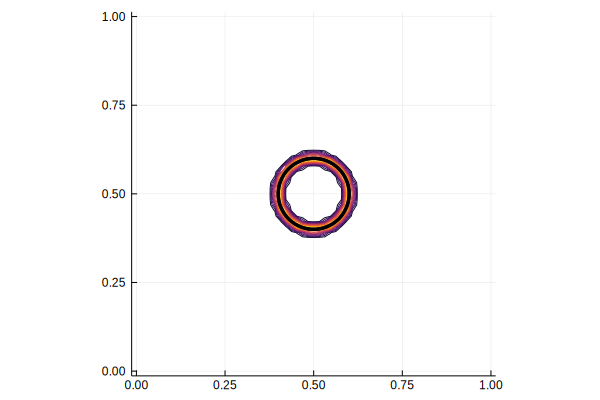

In [95]:
i_n = indices(s,1)
j_n = indices(s,2)
plot(xmap(i_n,s,params),ymap(j_n,s,params),s[i_n,j_n],legend=:false,ratio=1)
scatter!(pts.x,pts.y,ratio=1,markersize=1,markercolor=:black)

Note that the regularization preserves the sum of the data.

In [96]:
println("Sum of regularized field = ",sum(s))
println("Sum of point data = ",sum(f))

Sum of regularized field = 200.0
Sum of point data = 200.0


Interpolate back to the points

In [97]:
f2 = ScalarPoint(f)
@time interpolate!(f2,s,pts,params);

  0.247612 seconds (13.54 M allocations: 206.829 MiB, 14.03% gc time)


In [98]:
ds = 0.25*2π/N
ds/Δx

0.5026548245743669

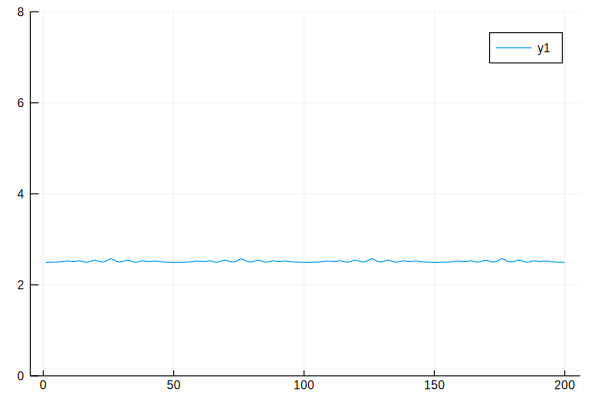

In [100]:
plot(f2,ylim=(0,8))

### Validate immersed boundary method with translating cylinder in open domain

Set up the body

In [336]:
xc = 0.3
yc = 0.5
R = 0.2
N = 100
f = ScalarPoint(ones(N))
pts = VectorPoint(f)
for pt in 1:N
    pts.x[pt] = xc + R*cos(2π*(pt-1)/N)
    pts.y[pt] = yc + R*sin(2π*(pt-1)/N)
end

Set up the body streamfunction values:

In [337]:
U = 1
V = 0
sb = ScalarPoint(pts)
sb .= U*(pts.y .- yc) - V*(pts.x .- xc);

Set up the domain

In [338]:
NX = 256
NY = 256

256

In [339]:
Δx = LX/NX

0.00390625

Set the boundary conditions on the wall of the enclosure

In [340]:
sL(y,t) = U*R^2*(y-yc)/((0-xc)^2+(y-yc)^2)
sR(y,t) = U*R^2*(y-yc)/((LX-xc)^2+(y-yc)^2)
sB(x,t) = U*R^2*(0-yc)/((0-yc)^2+(x-xc)^2)
sT(x,t) = U*R^2*(LX-yc)/((LX-yc)^2+(x-xc)^2)

sT (generic function with 1 method)

In [355]:
params = ScalarDirichletParameters(Δx,x0,y0,sL,sR,sB,sT)

ScalarDirichletParameters(0.00390625, 0.0, 0.0, sL, sR, sB, sT)

Create an operator for Schur complement,

$$S = EL^{-1}E^T$$

In [342]:
function schur!(y::AbstractVector,x::ScalarPoint{N},pts::VectorPoint{N},params::Parameters,s::NodeData,f::ScalarPoint{N}) where {N}
    fill!(s,0.0)
    regularize!(s,x,pts,params)
    poisson_dirichlet_fft!(s)
    fill!(f.data,0.0)
    interpolate!(f,s,pts,params)
    y .= f
    return y
end

# Set up some storage arrays
stmp = NodeData(NX,NY)
ftmp = ScalarPoint(N)
Sfcn(y::AbstractVector,x::AbstractVector) = schur!(y,ScalarPoint(x),pts,params,stmp,ftmp)

# Create a linear map for this function, for use in iterative solution
S = LinearMap(Sfcn,N;ismutating=true,issymmetric=true,isposdef=true)

LinearMaps.FunctionMap{Float64}(Sfcn, 100, 100; ismutating=true, issymmetric=true, ishermitian=true, isposdef=true)

In [360]:
function schur!(y::ScalarPoint{N},x::ScalarPoint{N},pts::VectorPoint{N},params::Parameters,s::NodeData,f::ScalarPoint{N}) where {N}
    fill!(s,0.0)
    regularize!(s,x,pts,params)
    poisson_dirichlet_fft!(s)
    fill!(f.data,0.0)
    interpolate!(f,s,pts,params)
    y .= f
    return y
end

# Set up some storage arrays
stmp = NodeData(NX,NY)
ftmp = ScalarPoint(N)
Sfcn(y::AbstractVector,x::AbstractVector) = schur!(ScalarPoint(y),ScalarPoint(x),pts,params,stmp,ftmp)

# Create a linear map for this function, for use in iterative solution
S = LinearMap(Sfcn,N;ismutating=true,issymmetric=true,isposdef=true)

LinearMaps.FunctionMap{Float64}(Sfcn, 100, 100; ismutating=true, issymmetric=true, ishermitian=true, isposdef=true)

#### First step: solve for s*

In [361]:
sstar = NodeData(NX,NY)
rhs = NodeData(sstar)
apply_bc!(sstar,0,params)
f̃ = Δx^2*rhs - laplacian(sstar);
sstar .= f̃
@time poisson_dirichlet_fft!(sstar)
apply_bc!(sstar,0,params);

  0.110560 seconds (102 allocations: 7.948 MiB, 93.15% gc time)


In [362]:
srhs = ScalarPoint(sb)
interpolate!(srhs,sstar,pts,params)
srhs .= sb - srhs
@time fvec,ch = cg(S,srhs.data,tol=1e-3,log=true);
f = ScalarPoint(fvec);

 11.601996 seconds (597.28 M allocations: 8.968 GiB, 10.37% gc time)


In [363]:
s = NodeData(NX,NY)
regularize!(s,f,pts,params)
poisson_dirichlet_fft!(s)
s .+= sstar
apply_bc!(s,0,params);

#### Exact solution

In [364]:
i_n = indices(s,1,interior=false)
j_n = indices(s,2,interior=false)
x_n = xmap(i_n,s,params)
y_n = ymap(j_n,s,params);

In [365]:
sexact = NodeData(s)
for j in j_n, i in i_n
    rsq = (x_n[i]-xc)^2+(y_n[j]-yc)^2
    if rsq > R^2
        sexact[i,j] = U*R^2*(y_n[j]-yc)/rsq
    else
        sexact[i,j] = U*(y_n[j]-yc)
    end
end

#### Plot the result

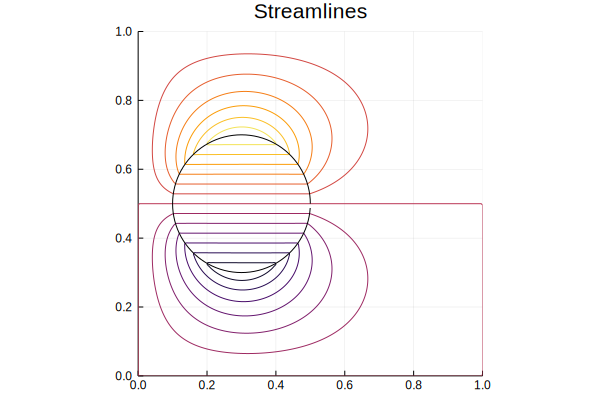

In [366]:
plot(x_n,y_n,transpose(s[i_n,j_n]),legend=:false,ratio=1,title="Streamlines")
plot!(pts.x,pts.y,ratio=1,markersize=1,linecolor=:black,xlim=(0,LX),ylim=(0,LX))

#### Error in streamfunction field

In [349]:
norm(s-sexact)/norm(sexact)

0.006155829927796278

#### Vortex sheet strength

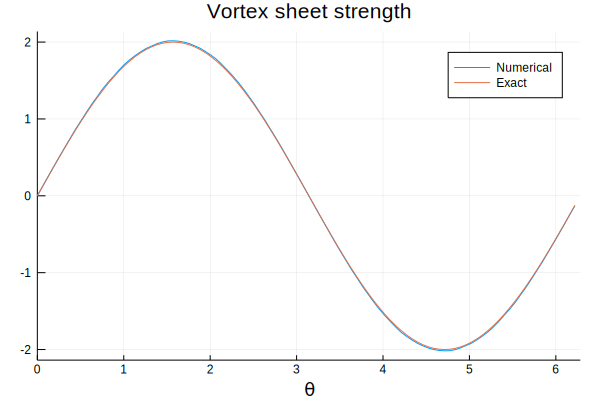

In [350]:
dθ = 2π/N
θ = 0:dθ:dθ*(N-1)
ds = R*dθ

# the strength distribution is the set of forces, divided by the arc distance between points
γ = -f/ds 

# The exact strength distribution
γex = 2*U*sin.(θ)

# plot them
plot(θ,γ,xlim=(0,2π),label="Numerical",title="Vortex sheet strength",xlabel="\\theta")
plot!(θ,γex,label="Exact")

### Now a more interesting shape

In [309]:
xc = 0.5
yc = 0.5
R = 0.2
N = 100
f = ScalarPoint(N)
pts = VectorPoint(f)

# Make a square

Δs = 2R/(N/4)
pt = 0
for j in 1:N/4
    pt += 1
    pts.x[pt] = (xc-R) + Δs*(j-1)
    pts.y[pt] = (yc-R)
end
for j in 1:N/4
    pt += 1
    pts.x[pt] = (xc-R) + 2R
    pts.y[pt] = (yc-R) + Δs*(j-1)
end
for j in 1:N/4
    pt += 1
    pts.x[pt] = (xc-R) + 2R-Δs*(j-1)
    pts.y[pt] = (yc-R) + 2R
end
for j in 1:N/4
    pt += 1
    pts.x[pt] = (xc-R)
    pts.y[pt] = (yc-R) + 2R-Δs*(j-1)
end

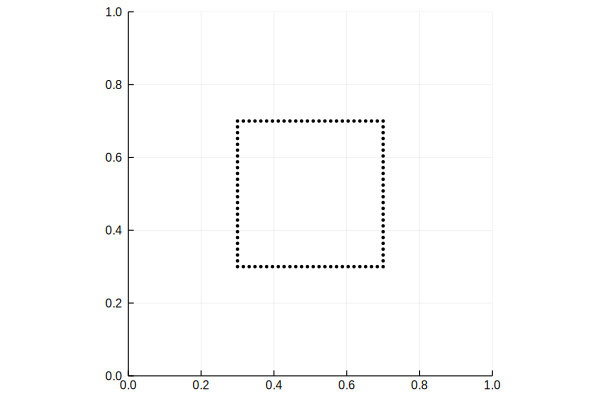

In [310]:
scatter(pts.x,pts.y,ratio=1,markersize=1,markercolor=:black,xlim=(0,1),ylim=(0,1),legend=:false)

Set up the motion

In [351]:
U = 1
V = 0
sb = ScalarPoint(pts)
sb .= U*(pts.y .- yc) - V*(pts.x .- xc);

Set up the domain

In [352]:
NX = 256
NY = 256

256

In [353]:
Δx = LX/NX

0.00390625

Set the boundary conditions on the wall of the enclosure

In [354]:
ψ0 = 0.0
sL(y,t) = ψ0
sR(y,t) = ψ0
sB(x,t) = ψ0
sT(x,t) = ψ0

sT (generic function with 1 method)

In [314]:
params = ScalarDirichletParameters(Δx,x0,y0,sL,sR,sB,sT)

ScalarDirichletParameters(0.00390625, 0.0, 0.0, sL, sR, sB, sT)

In [320]:
sstar = NodeData(NX,NY)
rhs = NodeData(sstar)
apply_bc!(sstar,0,params)
f̃ = Δx^2*rhs - laplacian(sstar);
sstar .= f̃
@time poisson_dirichlet_fft!(sstar)
apply_bc!(sstar,0,params);

  0.012589 seconds (102 allocations: 7.948 MiB, 48.51% gc time)


In [321]:
srhs = ScalarPoint(sb)
interpolate!(srhs,sstar,pts,params)
srhs .= sb - srhs
@time fvec,ch = cg(S,srhs.data,tol=1e-3,log=true);
f = ScalarPoint(fvec);

 25.937139 seconds (1.39 G allocations: 20.854 GiB, 12.01% gc time)


In [323]:
s = NodeData(NX,NY)
regularize!(s,f,pts,params)
poisson_dirichlet_fft!(s)
s .+= sstar
apply_bc!(s,0,params);

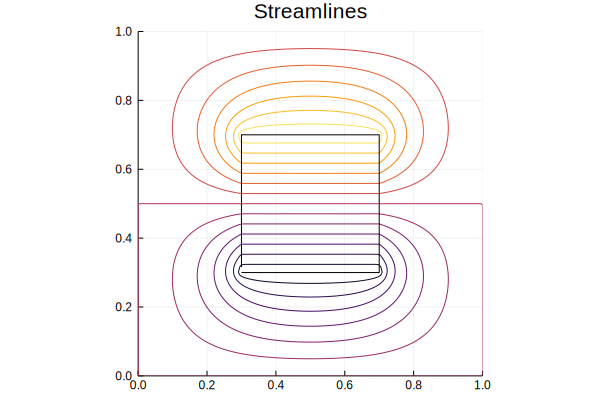

In [324]:
plot(x_n,y_n,transpose(s[i_n,j_n]),legend=:false,ratio=1,title="Streamlines")
plot!(pts.x,pts.y,ratio=1,markersize=1,linecolor=:black,xlim=(0,LX),ylim=(0,LX))

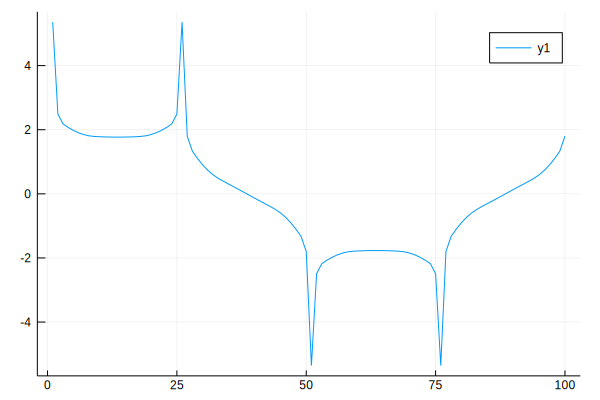

In [326]:
plot(f/Δs)

In [335]:
(sum(-pts.y.*f) - (2R)^2)/(2R)^2
sum(pts.x.*f)

1.317172730261329e-9

In [334]:
sum(pts.x.*f)

1.317172730261329e-9